In [2]:
from gurobipy import Model, GRB
import numpy as np
import torch
import matplotlib.pyplot as plt

# Toy problem in gurobi

In [11]:
def solve_gromov_wasserstein(mu, nu, G):
    """
    Solves the Gromov-Wasserstein quadratic program using Gurobi.

    Parameters:
        mu (numpy.ndarray): Source distribution, shape (n,).
        nu (numpy.ndarray): Target distribution, shape (m,).
        G (numpy.ndarray): Quadratic cost matrix, shape (nm, nm).

    Returns:
        numpy.ndarray: Optimal transport matrix T, shape (n, m).
    """
    # Dimensions
    n = len(mu)
    m = len(nu)

    # Create a Gurobi model
    model = Model("Gromov-Wasserstein")

    # Add variables for T (n x m), flattened as a single vector
    T = model.addVars(n, m, lb=0, vtype=GRB.CONTINUOUS, name="T")

    # Flatten T for indexing consistency
    T_vec = np.array([[T[i, j] for j in range(m)] for i in range(n)]).flatten()

    # Add marginal constraints
    # Row marginal: sum_j T[i, j] = mu[i]
    for i in range(n):
        model.addConstr(sum(T[i, j] for j in range(m)) == mu[i])

    # Column marginal: sum_i T[i, j] = nu[j]
    for j in range(m):
        model.addConstr(sum(T[i, j] for i in range(n)) == nu[j])

    # Objective function: 0.5 * T_vec' * G * T_vec
    obj = 0.5 * sum(
        G[i, j] * T_vec[i] * T_vec[j] for i in range(n * m) for j in range(n * m)
    )
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Extract solution
    if model.Status == GRB.OPTIMAL:
        T_opt = np.array([[T[i, j].X for j in range(m)] for i in range(n)])
        return T_opt, model
    else:
        print("Optimization failed!")
        return None, None


# Example usage
n = m = 5
mu = np.random.rand(n)
mu /= mu.sum()  # Normalize to sum to 1
nu = np.random.rand(m)
nu /= nu.sum()  # Normalize to sum to 1
G = np.random.rand(n * m, n * m)  # Random dense cost matrix
G = 0.5 * (G + G.T)  # Symmetrize G for numerical stability

T_optimal, model = solve_gromov_wasserstein(mu, nu, G)
print("Optimal Transport Matrix:\n", T_optimal)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Rocky Linux 8.10 (Green Obsidian)")

CPU model: Intel(R) Xeon(R) Platinum 8358 CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 64 physical cores, 64 logical processors, using up to 32 threads

Optimize a model with 10 rows, 25 columns and 50 nonzeros
Model fingerprint: 0xb03ef4e3
Model has 325 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 4e-01]
Presolve removed 1 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Presolve time: 0.00s
Presolved: 611 rows, 352 columns, 1576 nonzeros
Presolved model has 25 quadratic constraint(s)
Presolved model has 300 bilinear constraint(s)
Variable types: 352 continuous, 0 integer (0 binary)
Found heuristic solution: objective 0.1904564

Root relaxation: objective 0.000000e+00, 61 iterat

Verify objective

In [12]:
T_vec = T_optimal.flatten()
np.isclose(
    model.ObjVal,
    0.5
    * sum(G[i, j] * T_vec[i] * T_vec[j] for i in range(n * m) for j in range(n * m)),
)

np.True_

# Problem formulations: GW as QP

In [80]:
class Args:
    n_i = 10
    n_j = 10
    n_downsample_pix = 20
    top_k = 12
    exponent = 1
    scheduler = "none"
    element_wise = False
    cost_scale_factor = 1.0


args = Args()
torch_dtype = torch.float32

n_downsample_pix = args.n_downsample_pix
top_k = args.top_k
exponent = args.exponent
scheduler = args.scheduler
element_wise = args.element_wise
cost_scale_factor = args.cost_scale_factor

In [81]:
fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/processed_submissions/submission_23.pt"
submission = torch.load(fname, weights_only=False)
volumes = submission["volumes"].to(torch_dtype)
volumes_i = volumes[: args.n_i]
volumes_j = volumes[: args.n_j]

In [82]:
from gw_weighted_voxels import prepare_volume_and_distance

marginals_i = np.empty((len(volumes_i), top_k))
marginals_j = np.empty((len(volumes_j), top_k))
pairwise_distances_i = np.empty((len(volumes_i), top_k, top_k))
pairwise_distances_j = np.empty((len(volumes_j), top_k, top_k))

for i in range(len(volumes_i)):
    volume_i, pairwise_distance_i = prepare_volume_and_distance(
        volumes_i[i], top_k, n_downsample_pix, exponent, cost_scale_factor
    )
    marginals_i[i] = volume_i
    pairwise_distances_i[i] = pairwise_distance_i
for j in range(len(volumes_j)):
    volume_j, pairwise_distance_j = prepare_volume_and_distance(
        volumes_j[j], top_k, n_downsample_pix, exponent, cost_scale_factor
    )
    marginals_j[j] = volume_j
    pairwise_distances_j[j] = pairwise_distance_j

In [83]:
def generate_G(Cx, Cy):
    """
    Generate the quadratic cost matrix G for the Gromov-Wasserstein problem.

    Parameters:
        Cx (numpy.ndarray): Distance matrix for the source space, shape (n, n).
        Cy (numpy.ndarray): Distance matrix for the target space, shape (m, m).

    Returns:
        numpy.ndarray: Quadratic cost matrix G, shape (nm, nm).
    """
    n, m = Cx.shape[0], Cy.shape[0]

    # Initialize the G matrix with zeros
    G = np.zeros((n * m, n * m))

    # Fill in G using the formula
    for i in range(n):
        for j in range(m):
            for k in range(n):
                for el in range(m):
                    idx1 = i * m + j  # Flattened index for (i, j)
                    idx2 = k * m + el  # Flattened index for (k, l)
                    G[idx1, idx2] = (Cx[i, k] - Cx[j, k]) ** 2 + (
                        Cy[el, i] - Cy[el, j]
                    ) ** 2

    return G


gw_distance = np.zeros((len(volumes_i), len(volumes_j)))
for idx_i in range(len(volumes_i)):
    for idx_j in range(len(volumes_j)):
        if idx_i > idx_j:
            print(f"Computing GW distance between {idx_i} and {idx_j}...")

            n = m = top_k
            Cx = pairwise_distances_i[idx_i]
            Cy = pairwise_distances_j[idx_j]

            # Ensure the distance matrices are symmetric and non-negative
            Cx = 0.5 * (Cx + Cx.T)
            Cy = 0.5 * (Cy + Cy.T)
            Cx[Cx < 0] = 0
            Cy[Cy < 0] = 0

            G = generate_G(Cx, Cy)
            mu = marginals_i[idx_i]
            nu = marginals_j[idx_j]
            T_optimal, model = solve_gromov_wasserstein(mu, nu, G)
            gw_distance[idx_i, idx_j] = gw_distance[idx_j, idx_i] = model.ObjVal

Computing GW distance between 1 and 0...


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Rocky Linux 8.10 (Green Obsidian)")

CPU model: Intel(R) Xeon(R) Platinum 8358 CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 64 physical cores, 64 logical processors, using up to 32 threads

Optimize a model with 24 rows, 144 columns and 288 nonzeros
Model fingerprint: 0xa51fbeac
Model has 10346 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-04, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e-01]
Presolve removed 3 rows and 23 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 2 rows and 23 columns
Presolve time: 0.01s
Presolved: 14425 rows, 7435 columns, 36359 nonzeros
Presolved model has 111 quadratic constraint(s)
Presolved model has 7201 bilinear constraint(s)
Variable types: 7435 continuous, 0 integer (0 binary)
Found heuristic solution: objective 0.0118319


In [4]:
res = np.array(
    [
        0.0118319,
        0.0277069,
        0.0341689,
        0.0159176,
        0.0249998,
        0.0219756,
        0.0121917,
        0.000739781,
        0.0339335,
        0.0243869,
        0.0163812,
        0.0257288,
        0.0215024,
        0.0010569,
        0.0251218,
        0.0175441,
        0.0263011,
        0.021326,
        0.00126462,
        0.0257148,
        0.000704816,
        0.0183677,
        0.0274071,
        0.0226183,
        0.00106426,
        0.0268244,
        0.00125761,
        0.0008492,
        0.0178109,
        0.0266613,
        0.0213839,
        0.00153841,
        0.0260791,
        0.000819374,
        0.000338383,
        0.0010721,
        0.0177845,
        0.026316,
        0.0220346,
        0.00101973,
        0.0257333,
        0.000826876,
        0.000584359,
        0.000473581,
        0.000794224,
    ]
)
gw_distance = np.zeros((10, 10))
idx = 0
for idx_i in range(10):
    for idx_j in range(10):
        if idx_i > idx_j:
            gw_distance[idx_i, idx_j] = gw_distance[idx_j, idx_i] = res[idx]
            idx += 1

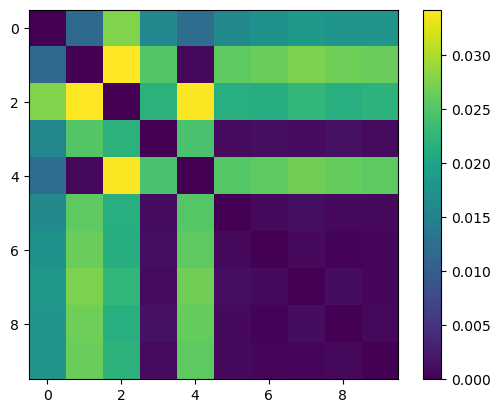

In [5]:
plt.imshow(gw_distance)
plt.colorbar()

In [ ]:
gw_distance